# Comparing HSIC versus Mutual Information measures

In this notebook, we will be exploring how we can estimate the HSIC parmaeter for different distributions and look at how it compares to MI measures. Normally the procedure for calculating HSIC is as follows:

1. Calculate kernel matrices for X and Y
2. Center both kernel matrices
3. Find the Frobenius norm between the kernel matrices

This works well but there is no certain way to estimate the parameter for each of the kernel matrices. There is another paper that is called the Kernel Tangent Alignment (KTA). This method is different as it is calculated like so:

1. Calculate the kernel matrices for X and Y
2. Find the Frobenius norm between the kernel matrices
3. Normalize the value by the Frobenius norm of X and Y individually

This works in a similar way to the HSIC method. The difference is that you do the normalization procedure. The final algorithm is the Centered Kernel Tangent Alignment (cKTA) method which is a combination of the previous two methods. The algorithm is as follows:

1. Calculate the kernel matrices for X and Y
2. Center both kernel matrices
3. Find the Frobenius norm between the kernel matrices
4. Normalize the value by the Frobenius norm of X and Y individually 

As you can see, it would appear that this method is the most complete in the sense that it incorporates all steps to ensure that our data is sufficiently scaled to a way that is directly comparable. This notebook will attempt to see which of these methods provides a good estimate for a sigma value for the kernel matrices and how do their output values compare to mutual information measures.

## Code

In [1]:
import sys, os
import warnings
import tqdm
import random
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

# toy datasets
from data.toy import generate_dependence_data

# Kernel Dependency measure
from models.dependence import HSIC, train_hsic
from models.kernel import estimate_sigma, sigma_to_gamma, gamma_to_sigma, get_param_grid

# RBIG IT measures
from models.ite_algorithms import run_rbig_models

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

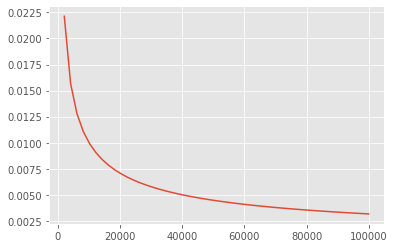

In [2]:
x = np.linspace(0, 100_000)
def f(x): return 1 / np.sqrt(x)

plt.plot(x, f(x))

## Example

### Data

No handles with labels found to put in legend.


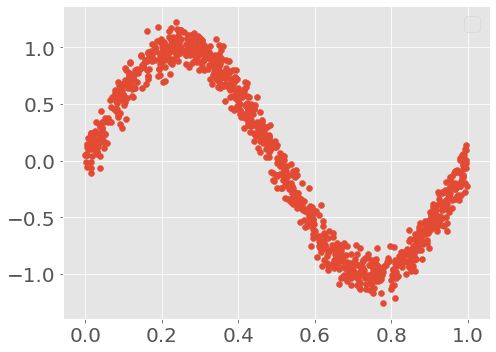

In [3]:
# data params
dataset = 'sine'
num_points = 1000
seed = 123
noise_x = 0.1
noise_y = 0.1

# get dataset
X, Y = generate_dependence_data(
    dataset=dataset,
    num_points=num_points,
    seed=seed,
    noise_x=noise_x,
    noise_y=noise_y
)

X_scale, Y_scale = X * 10, Y * 10
# plot

fig, ax = plt.subplots(nrows=1, figsize=(7, 5))

ax.scatter(X, Y)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

save_path = f'{cwd}/../../results/hsic/figures/demo/'
fig.savefig(f"{save_path}demo_{dataset}.png")

### HSIC Value

#### Original HSIC Value

In [7]:
# hsic params
kernel = 'rbf'
scorer = 'hsic'
subsample = None
bias = True

# initialize HSIC calculator
clf_hsic = HSIC(
    kernel=kernel, 
    scorer=scorer, 
    subsample=subsample,
    bias=bias
)

# calculate HSIC return scorer
clf_hsic.fit(X_scale, Y_scale);

# hsic value and kernel alignment score
hsic_val = clf_hsic.hsic_value

print(f"HSIC: {hsic_val:.5f}")

HSIC: 0.02911


#### Kernel Tangent Alignment

In [9]:
# hsic params
kernel = 'rbf'
scorer = 'tka'
subsample = None
bias = True

# initialize HSIC calculator
clf_hsic = HSIC(
    kernel=kernel, 
    scorer=scorer, 
    subsample=subsample,
    bias=bias
)


# calculate HSIC return scorer
clf_hsic.fit(X, Y);

# hsic value and kernel alignment score
tka_val = clf_hsic.hsic_value

print(f"TKA: {tka_val:.5f}")

TKA: 0.87495


#### Centered Kernel Tangent Alignment

In [10]:
# hsic params
kernel = 'rbf'
scorer = 'ctka'
subsample = None
bias = True

# initialize HSIC calculator
clf_hsic = HSIC(
    kernel=kernel, 
    scorer=scorer, 
    subsample=subsample,
    bias=bias
)


# calculate HSIC return scorer
clf_hsic.fit(X, Y);

# hsic value and kernel alignment score
tka_val = clf_hsic.hsic_value

print(f"TKA: {tka_val:.5f}")

TKA: 0.65111


### Problem Example

So here I will demonstrate one of the problems with trying to use HSIC without proper consideration of the parameters. I will vary the gamme value from 0.001 to 1000 and we'll see that the values for HSIC and cKTA will change depending upon the parameters.

In [23]:
# estimate sigma params
sigma_est = 'belkin'
factor = 1
n_gammas = 100

# Estimate Sigma
sigma_x = estimate_sigma(X, method=sigma_est)
sigma_y = estimate_sigma(Y, method=sigma_est)

# init overall sigma is mean between two
init_sigma = np.mean([sigma_x, sigma_y])

# get sigma parameter grid
sigmas = get_param_grid(init_sigma, factor, n_gammas)


gammas = sigma_to_gamma(sigmas)
init_gamma = sigma_to_gamma(init_sigma)

scorers = {
    'hsic': [], 
    'tka': [], 
    'ctka':[]
}
hsic_values = list()

# hsic model params
kernel = 'rbf'
subsample = None
bias = True

for iscorer in scorers:
    for igamma in gammas:
        
        clf_hsic = HSIC(
            kernel=kernel, 
            scorer=iscorer,
            gamma=igamma,
            subsample=subsample,
            bias=bias
        )

        # calculate HSIC return scorer
        clf_hsic.fit(X, Y);

        # hsic value and kernel alignment score
        scorers[iscorer].append(clf_hsic.score(X))

In [24]:
def plot_max_hsic(results_list, scorer='hsic', function='line', sigma_est='mean', save=True):
    
    save_path = f'{cwd}/../../results/hsic/figures/demo/'
    
    fig, ax = plt.subplots(nrows=1, figsize=(7, 5))
    
    # MAX HSIC Values
    max_idx = np.argmax(scorers[scorer])
    hsic_max = scorers[scorer][max_idx]
    gamma_max = gammas[max_idx]
    print(f'Max {scorer.upper()}: {hsic_max:.4f}')
    print(f'Max Gamma ({scorer.upper()}): {gamma_max:.4f}\n')

    # init HSIC Values
    init_hsic = HSIC(gamma=init_gamma, scorer=scorer).fit(X, Y).score(X)

    ax.set_xscale('log')
    ax.plot(gammas, scorers[scorer], color='red', linewidth=10, zorder=0)
    ax.scatter(gamma_max, hsic_max, s=300, c='yellow', label=f'Max Value', zorder=1)
    ax.scatter(init_gamma, init_hsic, s=300, c='black', label='Initial Value', zorder=1)
    ax.set_xlabel('$\gamma$', fontsize=20)
    ax.set_ylabel(f'{scorer.upper()}', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()
    
    if save:
        fig.savefig(f"{save_path}demo_{function}_{sigma_est}_{scorer}.png")
    return None

Max HSIC: 0.0662
Max Gamma (HSIC): 6.6399



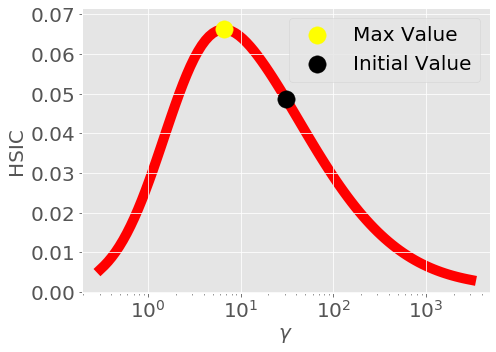

Max TKA: 0.9658
Max Gamma (TKA): 0.3082



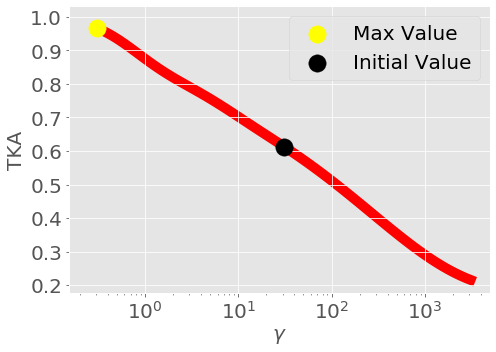

Max CTKA: 0.6532
Max Gamma (CTKA): 1.3655



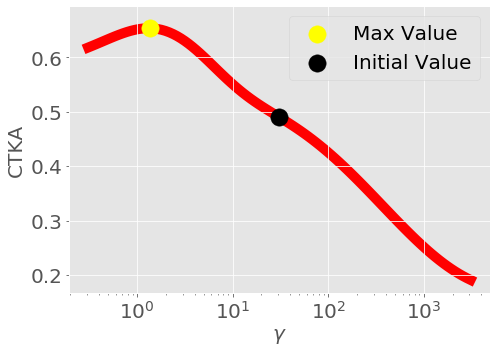

In [25]:
plot_max_hsic(scorers, 'hsic', dataset, sigma_est)
plot_max_hsic(scorers, 'tka', dataset, sigma_est)
plot_max_hsic(scorers, 'ctka', dataset, sigma_est)

So as you can see, there exists some space of gamma that would fit our problem and the actual value of HSIC and cKTA changes. I also don't see any direct correspondence between the two values. Neither really make sense. There is a maximum HSIC value but that doesn't necessarily mean it's the best one.

## Experiment

For this experiment, I would like to investigate how each of the scores measure different datasets of varying dependency/correlation structures. 

I will look at the following parameters:
* $\sigma$ - the measure of spread
    * Sigma initialization (Scott, Silverman, Mean, Median)
* HSIC values
* function

**Note**: Technically I would need one sigma value per dataset. But for this first experiment I will keep them fixed.

#### Parameter I - Gammas

I will vary the gamma (sigma) parameter by means of an ad-hoc initialization. I start with the mean distance between all of the points and then vary that by a factor of 2 in both directions (more and less). 

In [14]:
sigma_init = 'mean'

sigma_x = estimate_sigma(X, method=sigma_init)
sigma_y = estimate_sigma(Y, method=sigma_init)

print(f"Estimated sigma (X): {sigma_x:.4f}")
print(f"Estimated sigma (Y): {sigma_y:.4f}")

Estimated sigma (X): 0.3292
Estimated sigma (Y): 0.8206


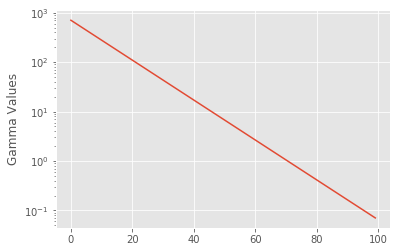

In [15]:
# get parameter grid
sigmas = np.logspace(np.log10(sigma_x * 0.1), np.log10(sigma_x * 10), 100)

# convert to gammas
init_gamma = np.mean([sigma_x, sigma_y])
gamma_params = sigma_to_gamma(sigmas)

fig, ax = plt.subplots()

ax.set_yscale('log')
ax.plot(gammas)
ax.set_ylabel('Gamma Values')

plt.show()

#### Parameter II - Noise Values

I will vary the noise parameter to something reasonable. Ranging from 0.001 to 0.5.

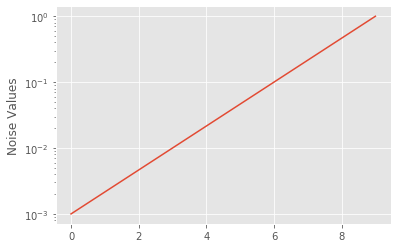

In [16]:
noise_params = np.logspace(-3, -0, 10)


fig, ax = plt.subplots()

ax.set_yscale('log')
ax.plot(noise_params)
ax.set_ylabel('Noise Values')

plt.show()

### Parameter III - Functions

I will use 4 different function types to draw samples from:

* Linear Function
* Sine Function
* Circular Function
* Completely Random

In [23]:
func_params = [
    'line',
    'sine',
    'circ',
    'rand'
]



## Run Experiment

In [28]:
# initialize results dataframe
results_df = pd.DataFrame(columns=[
    'function',
    'noise',
    'init_gamma',
    'gamma',
    'scorer',
    'value',
    'mi',
])


for ifunction in func_params:
    print(f"Function: {ifunction}")
    
    for inoise in noise_params:
        print(f"Noise: {inoise}")

        # Generate data
        num_points = 1000
        seed = 123
        noise_x = inoise
        noise_y = inoise

        # get dataset
        X, Y = generate_dependence_data(
            dataset=ifunction,
            num_points=num_points,
            seed=seed,
            noise_x=noise_x,
            noise_y=noise_y
        )
        
        # Mutual Information
        it_measure = 'mi'
        mi_score, t_ = run_rbig_models(
            X, Y, 
            measure=it_measure, 
            verbose=None, 
            random_state=123
        )
        
        
        init_sigma_x = estimate_sigma(X, method='median')
        init_sigma_y = estimate_sigma(Y, method='median')
        init_sigma = np.mean([init_sigma_x, init_sigma_y])
        sigmas = get_param_grid(init_sigma, 1, 20)

        gammas = sigma_to_gamma(sigmas)

#                 with tqdm.tqdm(gamma_params, desc='Gamma Loop') as pbar_gamma:
        for igamma in gamma_params:

            # hsic params
            scorer = 'ctka'

            # initialize HSIC calculator
            clf_hsic = HSIC(gamma=igamma, scorer=scorer)

            # calculate HSIC return scorer
            clf_hsic.fit(X, Y);

            # hsic value and kernel alignment score
            hsic_score = clf_hsic.hsic_value
            tka_score = clf_hsic.score(X)

            # hsic params
            scorer = 'tka'

            # initialize HSIC calculator
            clf_hsic = HSIC(gamma=igamma, scorer=scorer)

            # calculate HSIC return scorer
            clf_hsic.fit(X, Y);

            # hsic value and kernel alignment score
            ctka_score = clf_hsic.score(X)
            
            # Save data
            results_df = results_df.append({
                'function': ifunction,
                'noise': inoise,
                'init_gamma': init_gamma,
                'gamma': igamma,
                'scorer': 'hsic',
                'value': hsic_score,
                'mi': mi_score
            }, ignore_index=True)
            
            # Save data
            results_df = results_df.append({
                'function': ifunction,
                'noise': inoise,
                'init_gamma': init_gamma,
                'gamma': igamma,
                'scorer': 'tka',
                'value': tka_score,
                'mi': mi_score
            }, ignore_index=True)

            # Save data
            results_df = results_df.append({
                'function': ifunction,
                'noise': inoise,
                'init_gamma': init_gamma,
                'gamma': igamma,
                'scorer': 'ctka',
                'value': ctka_score,
                'mi': mi_score
            }, ignore_index=True)


Function: line
Noise: 0.001
Noise: 0.0021544346900318843
Noise: 0.004641588833612777
Noise: 0.01
Noise: 0.021544346900318832
Noise: 0.046415888336127774
Noise: 0.1
Noise: 0.21544346900318823
Noise: 0.46415888336127775
Noise: 1.0
Function: sine
Noise: 0.001
Noise: 0.0021544346900318843
Noise: 0.004641588833612777
Noise: 0.01
Noise: 0.021544346900318832
Noise: 0.046415888336127774
Noise: 0.1
Noise: 0.21544346900318823
Noise: 0.46415888336127775
Noise: 1.0
Function: circ
Noise: 0.001
Noise: 0.0021544346900318843
Noise: 0.004641588833612777
Noise: 0.01
Noise: 0.021544346900318832
Noise: 0.046415888336127774
Noise: 0.1
Noise: 0.21544346900318823
Noise: 0.46415888336127775
Noise: 1.0
Function: rand
Noise: 0.001
Noise: 0.0021544346900318843
Noise: 0.004641588833612777
Noise: 0.01
Noise: 0.021544346900318832
Noise: 0.046415888336127774
Noise: 0.1
Noise: 0.21544346900318823
Noise: 0.46415888336127775
Noise: 1.0
